## Pipeline

Almost there! To obtain the final speech regions, we need to apply a detection threshold.  
For that, we rely on the voice activity detection pipeline whose hyper-parameters are set manually:
- `onset=0.6`: mark region as `active` when probability goes above 0.6
- `offset=0.4`: switch back to `inactive` when probability goes below 0.4
- `min_duration_on=0.0`: remove `active` regions shorter than that many seconds
- `min_duration_off=0.0`: fill `inactive` regions shorter than that many seconds


More details about those hyper-parameters are provided in Figure 2 of [that paper](https://arxiv.org/abs/2104.04045).

In [56]:
#model is your pretrained/finetuned/trained model name
from pyannote.audio.pipelines import VoiceActivityDetection as VoiceActivityDetectionPipeline
pipeline = VoiceActivityDetectionPipeline(segmentation=model)
initial_params = {"onset": 0.6, "offset": 0.4, 
                  "min_duration_on": 0.0, "min_duration_off": 0.0}
pipeline.instantiate(initial_params)

Here we go:

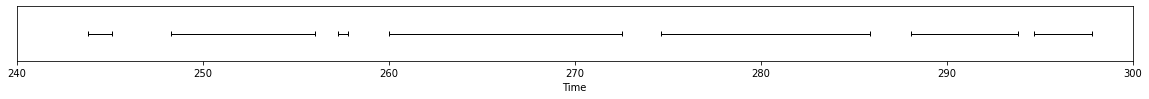

In [76]:
pipeline(test_file).get_timeline()

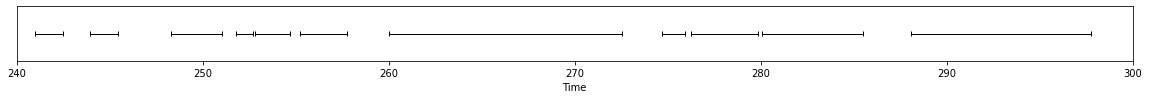

In [77]:
expected_output

Looks decent! Let's perform a proper evaluation by computing the [detection error rate](https://pyannote.github.io/pyannote-metrics/reference.html#detection) over the whole AMI test set:

In [54]:
from pyannote.metrics.detection import DetectionErrorRate
metric = DetectionErrorRate()

for file in ami.test():
    
    # apply the voice activity detection pipeline
    speech = pipeline(file)

    # evaluate its output
    _ = metric(
        file['annotation'],     # this is the reference annotation
        speech,                 # this is the hypothesized annotation
        uem=file['annotated'])  # this is the part of the file that should be evaluated
    
# aggregate the performance over the whole test set
detection_error_rate = abs(metric)
print(f'Detection error rate = {detection_error_rate * 100:.1f}%')

Detection error rate = 7.3%


## Optimizing pipeline hyper-parameters

While good enough, the hyper-parameters that we chose manually, we can try to optimize `onset` and `offset` on the development (a.k.a. validation) set to get better performance (and freeze the other two hyper-parameters).

In [60]:
pipeline.freeze({'min_duration_on': 0.0, 'min_duration_off': 0.0})

In [63]:
from pyannote.pipeline import Optimizer

optimizer = Optimizer(pipeline)
optimizer.tune(list(ami.development()), 
               warm_start=initial_params, 
               n_iterations=20, 
               show_progress=False)

optimized_params = optimizer.best_params

There you go: better hyper-parameters that (should) lead to better results!

In [78]:
print(optimized_params)

{'onset': 0.8020095763639215, 'offset': 0.5643079355945013, 'min_duration_on': 0.0, 'min_duration_off': 0.0}


Let's evaluate the voice activity detection pipeline with this new set of hyper-parameters:

In [79]:
optimized_pipeline = pipeline.instantiate(optimized_params)

metric = DetectionErrorRate()

for file in ami.test():
    speech = optimized_pipeline(file)
    _ = metric(file['annotation'], speech, uem=file['annotated'])
    
detection_error_rate = abs(metric)
print(f'Detection error rate = {detection_error_rate * 100:.1f}%')

Detection error rate = 6.9%


🎉 Yeay! 5% relativement improvement simply by tuning the thresholds.